In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
import xgboost
%matplotlib inline

from subprocess import check_output
print(check_output(["ls", "input/"]).decode("utf8"))

fastest_routes_test.csv
fastest_routes_train_part_1.csv
fastest_routes_train_part_2.csv
test.csv
train.csv
weather_data_nyc_centralpark_2016.csv



In [2]:
df = pd.read_csv('input/train.csv')
df.passenger_count = df.passenger_count.astype(np.uint8)
df.vendor_id = df.vendor_id.astype(np.uint8)
df.trip_duration = df.trip_duration.astype(np.uint32)
for c in [c for c in df.columns if c.endswith('tude')]:
    df.loc[:,c] = df[c].astype(np.float32)
print(df.memory_usage().sum()/2**20)
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)
df.dropoff_datetime=pd.to_datetime(df.dropoff_datetime)
df['pu_hour'] = df.pickup_datetime.dt.hour
df['yday'] = df.pickup_datetime.dt.dayofyear
df['wday'] = df.pickup_datetime.dt.dayofweek
df['month'] = df.pickup_datetime.dt.month

75.11792755126953


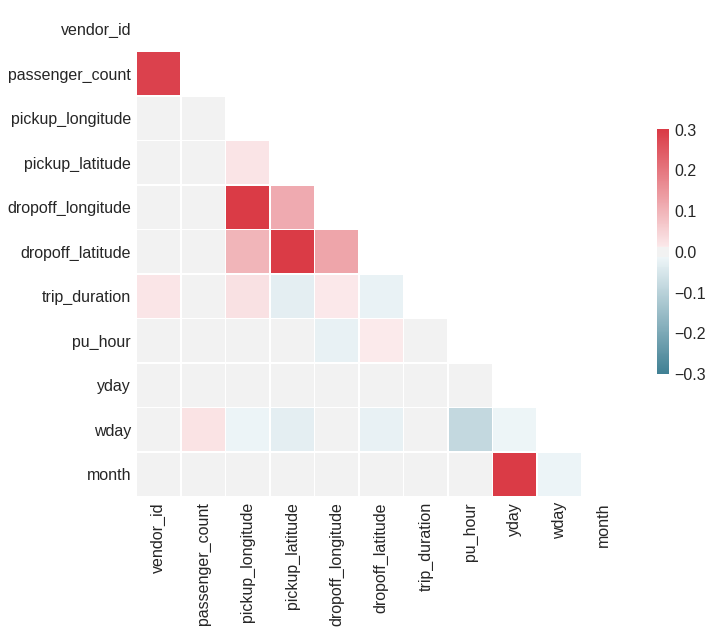

In [3]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

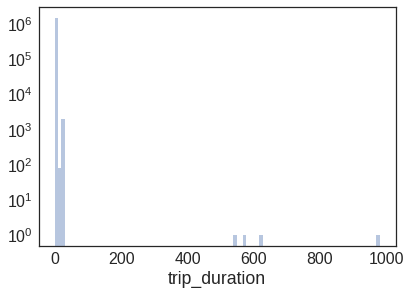

In [4]:
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.distplot(df['trip_duration']/3600,ax=ax,bins=100,kde=False,hist_kws={'log':True})

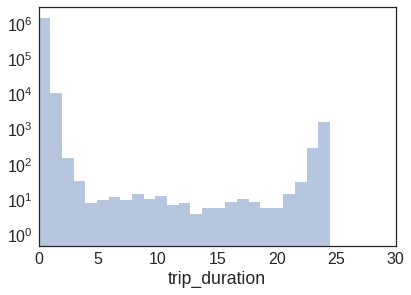

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_xlim(0,30)
sns.distplot(df['trip_duration']/3600,ax=ax,bins=1000,kde=False,hist_kws={'log':True})

In [4]:
def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    miles = km *  0.621371
    return miles

In [5]:
df['distance'] = haversine(df.pickup_longitude, df.pickup_latitude,
                                           df.dropoff_longitude, df.dropoff_latitude)

In [6]:
wdf = pd.read_csv('input/weather_data_nyc_centralpark_2016.csv')

In [7]:
wdf['date']=pd.to_datetime(wdf.date,format='%d-%m-%Y')
wdf['yday'] = wdf.date.dt.dayofyear

In [8]:
wdf.head()

,date,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth,yday
0,2016-01-01,42,34,38.0,0.00,0.0,0,1
1,2016-01-02,40,32,36.0,0.00,0.0,0,2
2,2016-01-03,45,35,40.0,0.00,0.0,0,3
3,2016-01-04,36,14,25.0,0.00,0.0,0,4
4,2016-01-05,29,11,20.0,0.00,0.0,0,5


In [9]:
wdf['snowfall'] = wdf['snow fall'].replace(['T'],0.05).astype(np.float32)
wdf['precipitation'] = wdf['precipitation'].replace(['T'],0.05).astype(np.float32)
wdf['snowdepth'] = wdf['snow depth'].replace(['T'],0.05).astype(np.float32)

In [10]:
df = pd.merge(df,wdf,on='yday')
df = df.drop(['date','maximum temerature','minimum temperature'],axis=1)
#df.head()

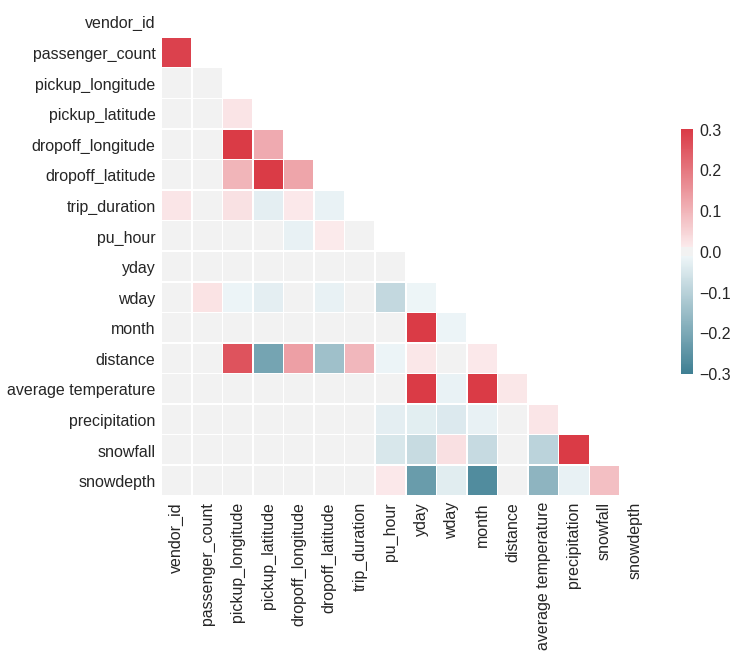

In [11]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

In [57]:
corr

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pu_hour,yday,wday,month,distance,average temperature
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304,0.009299,-0.006025,0.001311,-0.006221,0.008109,-0.005760
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471,0.009101,-0.001784,0.025191,-0.002143,0.010306,-0.001203
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542,0.010150,0.004263,-0.016356,0.004474,0.259780,0.005547
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204,0.010603,-0.002516,-0.028976,-0.001439,-0.210354,-0.002011
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678,-0.022455,0.004612,-0.001130,0.004758,0.134033,0.005502
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677,0.013612,-0.001554,-0.021762,-0.000607,-0.142128,-0.000997
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000,0.003690,0.006625,-0.000708,0.006607,0.094777,0.004574
pu_hour,0.009299,0.009101,0.010150,0.010603,-0.022455,0.013612,0.003690,1.000000,-0.003340,-0.084255,-0.003438,-0.015813,-0.004948
yday,-0.006025,-0.001784,0.004263,-0.002516,0.004612,-0.001554,0.006625,-0.003340,1.000000,-0.013615,0.985657,0.016443,0.837212
wday,0.001311,0.025191,-0.016356,-0.028976,-0.001130,-0.021762,-0.000708,-0.084255,-0.013615,1.000000,-0.014544,0.007599,-0.019799


In [18]:
fastest1 = pd.read_csv('input/fastest_routes_train_part_1.csv')
fastest2 = pd.read_csv('input/fastest_routes_train_part_2.csv')
fastest = pd.concat([fastest1,fastest2],ignore_index=True)
fastest = fastest.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps','starting_street','end_street'],axis=1)
fastest.head() #

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


In [19]:
df = pd.merge(df,fastest,on='id',how='outer')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,3,0.930648,45.5,0.29,0.0,0,0.0,0.0,2009.1,164.9
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,...,3,1.224526,45.5,0.29,0.0,0,0.0,0.0,2782.9,244.6
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,...,3,1.563173,45.5,0.29,0.0,0,0.0,0.0,3124.4,419.9
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,...,3,1.803944,45.5,0.29,0.0,0,0.0,0.0,3327.8,280.8
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,...,3,1.382826,45.5,0.29,0.0,0,0.0,0.0,3354.8,270.3


In [20]:
mask = ((df.trip_duration > 60) & (df.distance < 0.05))
df = df[~mask]
mask = (df.trip_duration < 60) 
df = df[~mask]
mask =  df.trip_duration > 79200
df = df[~mask]
mask = df.distance/(df.trip_duration/3600) > 60
df = df[~mask]
df.trip_duration = df.trip_duration.astype(np.uint16)
df = df[df.passenger_count > 0]

In [21]:
m = df.groupby(['wday','vendor_id'])[['trip_duration']].apply(np.median)
m.name = 'trip_duration_median'
df = df.join(m, on=['wday','vendor_id'])

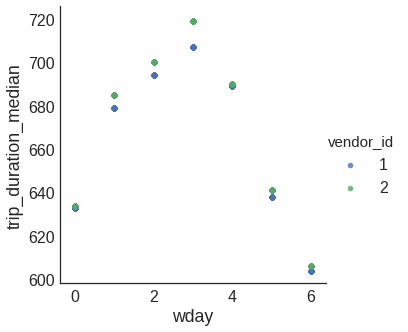

In [17]:
sns.lmplot(y='trip_duration_median', x='wday',data=df, fit_reg=False, hue='vendor_id')

In [22]:
m = df.groupby(['pu_hour','vendor_id'])[['trip_duration']].apply(np.median)
m.name ='trip_duration_median_hour'
df = df.join(m, on=['pu_hour','vendor_id'])

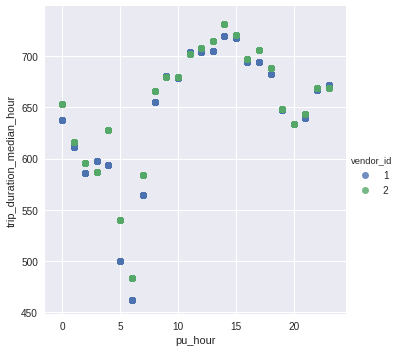

In [9]:
sns.lmplot(y='trip_duration_median_hour', x='pu_hour',data=df, fit_reg=False, hue='vendor_id')

In [23]:
jfk_lon = -73.778889
jfk_lat = 40.639722
lga_lon = -73.872611
lga_lat = 40.77725

In [25]:
df['jfk_pickup_dist'] = df.apply(lambda row: haversine(jfk_lon, jfk_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
df['lga_pickup_dist'] = df.apply(lambda row: haversine(lga_lon, lga_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
df['jfk_dropoff_dist'] = df.apply(lambda row: haversine(jfk_lon, jfk_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
df['lga_dropoff_dist'] = df.apply(lambda row: haversine(lga_lon, lga_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)

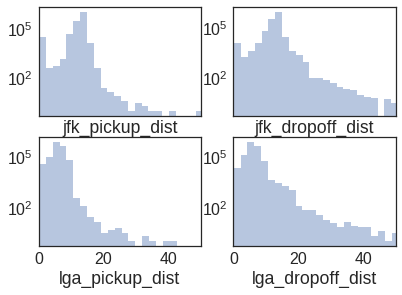

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True)
ax[0,0].set_xlim(0,50)

sns.distplot(df['jfk_pickup_dist'],ax=ax[0,0],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df['jfk_dropoff_dist'],ax=ax[0,1],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df['lga_pickup_dist'],ax=ax[1,0],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df['lga_dropoff_dist'],ax=ax[1,1],bins=100,kde=False,hist_kws={'log':True})

In [27]:
df['jfk'] = ((df['jfk_pickup_dist'] < 2) | (df['jfk_dropoff_dist'] < 2))
df['lga'] = ((df['lga_pickup_dist'] < 2) | (df['lga_dropoff_dist'] < 2))
df = df.drop(['jfk_pickup_dist','lga_pickup_dist','jfk_dropoff_dist','lga_dropoff_dist'],axis=1)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time,trip_duration_median,trip_duration_median_hour,jfk,lga
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0.0,0,0.0,0.0,2009.1,164.9,634.0,709.0,False,False
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,...,0.0,0,0.0,0.0,2782.9,244.6,633.0,727.0,False,False
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,...,0.0,0,0.0,0.0,3124.4,419.9,633.0,724.0,False,False
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,...,0.0,0,0.0,0.0,3327.8,280.8,634.0,633.5,False,False
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,...,0.0,0,0.0,0.0,3354.8,270.3,634.0,735.0,False,False


In [28]:
df['workday'] = ((df['pu_hour'] > 8) & (df['pu_hour'] < 18))
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,snow depth,snowfall,snowdepth,total_distance,total_travel_time,trip_duration_median,trip_duration_median_hour,jfk,lga,workday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,0.0,0.0,2009.1,164.9,634.0,709.0,False,False,True
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,...,0,0.0,0.0,2782.9,244.6,633.0,727.0,False,False,True
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,...,0,0.0,0.0,3124.4,419.9,633.0,724.0,False,False,True
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,...,0,0.0,0.0,3327.8,280.8,634.0,633.5,False,False,False
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,...,0,0.0,0.0,3354.8,270.3,634.0,735.0,False,False,True


## Locations

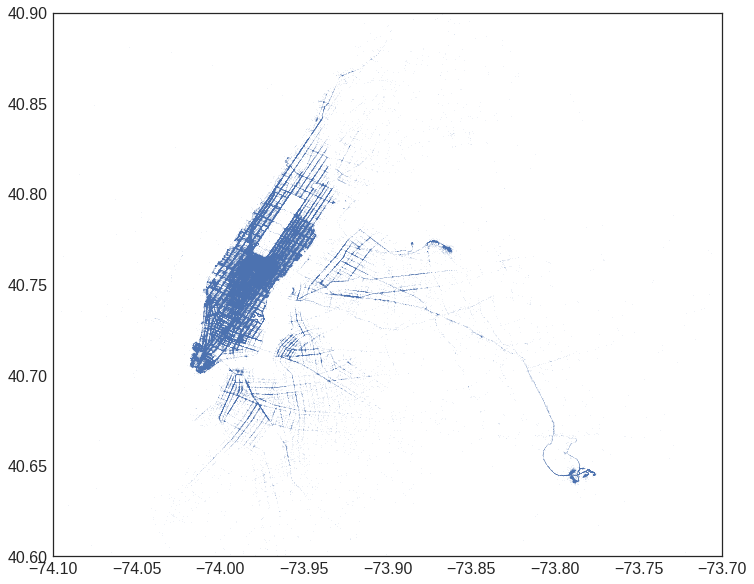

In [69]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(df['pickup_longitude'],df['pickup_latitude'], s=0.01, alpha=1)

## RMSLE: Evaluation Metric

In [5]:
def rmsle(evaluator,X,real):
    sum = 0.0
    predicted = evaluator.predict(X)
    print("Number predicted less than 0: {}".format(np.where(predicted < 0)[0].shape))

    predicted[predicted < 0] = 0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p-r)**2
    return (sum/len(predicted))**0.5

## Load Test Data

In [31]:
tdf = pd.read_csv('input/test.csv')
tdf.pickup_datetime=pd.to_datetime(tdf.pickup_datetime)
#tdf.dropoff_datetime=pd.to_datetime(tdf.dropoff_datetime)
tdf['pu_hour'] = tdf.pickup_datetime.dt.hour
tdf['yday'] = tdf.pickup_datetime.dt.dayofyear
tdf['wday'] = tdf.pickup_datetime.dt.dayofweek
tdf['month'] = tdf.pickup_datetime.dt.month
tdf['distance'] = haversine(tdf.pickup_longitude, tdf.pickup_latitude,
                                           tdf.dropoff_longitude, tdf.dropoff_latitude)
fastest_test = pd.read_csv('input/fastest_routes_test.csv')
tdf = pd.merge(tdf,fastest_test,on='id',how='outer')
tdf = tdf.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps','starting_street','end_street'],axis=1)
tdf = pd.merge(tdf,wdf,on='yday')
tdf = tdf.drop(['date','maximum temerature','minimum temperature'],axis=1)
tdf['jfk_pickup_dist'] = tdf.apply(lambda row: haversine(jfk_lon, jfk_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
tdf['lga_pickup_dist'] = tdf.apply(lambda row: haversine(lga_lon, lga_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
tdf['jfk_dropoff_dist'] = tdf.apply(lambda row: haversine(jfk_lon, jfk_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
tdf['lga_dropoff_dist'] = tdf.apply(lambda row: haversine(lga_lon, lga_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
tdf['jfk'] = ((tdf['jfk_pickup_dist'] < 2) | (tdf['jfk_dropoff_dist'] < 2))
tdf['lga'] = ((tdf['lga_pickup_dist'] < 2) | (tdf['lga_dropoff_dist'] < 2))
tdf = tdf.drop(['jfk_pickup_dist','lga_pickup_dist','jfk_dropoff_dist','lga_dropoff_dist'],axis=1)
tdf['workday'] = ((tdf['pu_hour'] > 8) & (tdf['pu_hour'] < 18))

In [70]:
tdf['snowfall'] = tdf['snow fall'].replace(['T'],0.05)
tdf['precipitation'] = tdf['precipitation'].replace(['T'],0.05)
tdf['snowdepth'] = tdf['snow depth'].replace(['T'],0.05)

In [71]:
tdf.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pu_hour,...,step_location_list,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,jfk,lga,workday
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,...,"-73.988109,40.732021|-73.976697,40.747615|-73....",76.0,0.0,0,0,0,0,False,False,False
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,...,"-73.96419,40.679994|-73.960956,40.663285|-73.9...",76.0,0.0,0,0,0,0,False,False,False
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,...,"-73.997421,40.737604|-73.990752,40.734816|-73....",76.0,0.0,0,0,0,0,False,False,False
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,...,"-73.956096,40.771911",76.0,0.0,0,0,0,0,False,False,False
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,...,"-73.970262,40.761412|-73.960671,40.757364|-73....",76.0,0.0,0,0,0,0,False,False,False


In [34]:
df.to_csv('train_data.csv',index=False)
tdf.to_csv('test_data.csv',index=False)

In [2]:
df = pd.read_csv('train_data.csv')
tdf = pd.read_csv('test_data.csv')

/n/home12/rebecca.krall/.conda/envs/py3xg/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/n/home12/rebecca.krall/.conda/envs/py3xg/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Benchmark Model

In [38]:
benchmark = fastest_test[['id','total_travel_time']]
benchmark = benchmark.rename(index=str, columns={"total_travel_time": "trip_duration"})
benchmark.head()

,id,trip_duration
0,id3004672,424.6
1,id3505355,200.0
2,id1217141,193.2
3,id1598245,103.2
4,id0898117,489.2


In [39]:
benchmark['trip_duration'].isnull().values.any()
benchmark.to_csv('benchmark.csv',index=False)
#RMSLE=0.990

In [3]:
features = df[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','workday','precipitation','snowfall','snowdepth','total_distance','total_travel_time','jfk','lga']]
target = df['trip_duration']

In [4]:
tfeatures = tdf[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','workday','precipitation','snowfall','snowdepth','total_distance','total_travel_time','jfk','lga']]

## Linear Regression

In [66]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv, scoring=rmsle))
reg.fit(features, target)

Number predicted less than 0: (14,)
Number predicted less than 0: (9,)
Number predicted less than 0: (17,)
Number predicted less than 0: (12,)
[ 0.43999617  0.44022755  0.43897449  0.44073678]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
np.mean([0.43999617,  0.44022755 , 0.43897449,0.44073678])

0.43998374750000002

In [74]:
tfeatures.shape

(625134, 17)

In [73]:
pred = reg.predict(tfeatures)
print(np.where(pred < 0)[0].shape)
pred[pred < 0]=0

(490,)


In [27]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]

In [28]:
out['trip_duration'].isnull().values.any()

False

In [29]:
out.to_csv('pred_linear.csv',index=False)
#RMSLE=0.535

## K-nearest Neighbors Regression

In [8]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=10)
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(neigh, features, np.ravel(target), cv=cv,scoring=rmsle))
neigh.fit(features,target)

Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
[ 0.42010954  0.41940803  0.41947931  0.41968818]


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

In [16]:
np.mean([0.42010954, 0.41940803, 0.41947931, 0.41968818])

0.41967126500000002

In [11]:
pred = neigh.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

(0,)


In [35]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out.to_csv('pred_knn.csv',index=False)
#RMSLE=0.505

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(rf, features, np.ravel(target), cv=cv,scoring=rmsle))
rf = rf.fit(features,np.ravel(target))

Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
[ 0.35085909  0.35181223  0.34976928  0.35057147]


In [15]:
np.mean([0.35085909, 0.35181223, 0.34976928, 0.35057147])

0.35075301749999999

In [13]:
pred = rf.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

(0,)


In [44]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out.to_csv('pred_rf.csv',index=False)
#RMSLE=0.473

## XGBoost

In [6]:
reg = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv,scoring=rmsle))
reg.fit(features,target)

/n/home12/rebecca.krall/.conda/envs/py3xg/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Number predicted less than 0: (1,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
[ 0.34347654  0.34348951  0.34196095  0.34286041]


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [8]:
pred = reg.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

(1,)


In [10]:
pred[pred < 0] = 0
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out['trip_duration'].isnull().values.any()
out.to_csv('pred_xgboost.csv',index=False)
#RMSLE=0.463

In [ ]:
from xgboost import plot_tree
plot_tree(reg)

In [12]:
import pickle
pickle.dump(reg, open('xgb_model.sav','wb'),protocol=2)